#Import the Necessery Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

Read and check the data set


In [30]:
df = pd.read_csv("SuperStore_Sales_Dataset.csv")
df.columns = df.columns.str.strip().str.lower()
print(df.shape)
print(df.columns.tolist())
df.head()

(5901, 23)
['row id+o6g3a1:r6', 'order id', 'order date', 'ship date', 'ship mode', 'customer id', 'customer name', 'segment', 'country', 'city', 'state', 'region', 'product id', 'category', 'sub-category', 'product name', 'sales', 'quantity', 'profit', 'returns', 'payment mode', 'ind1', 'ind2']


,row id+o6g3a1:r6,order id,order date,ship date,ship mode,customer id,customer name,segment,country,city,...,category,sub-category,product name,sales,quantity,profit,returns,payment mode,ind1,ind2
0,4918,CA-2019-160304,01-01-2019,07-01-2019,Standard Class,BM-11575,Brendan Murry,Corporate,United States,Gaithersburg,...,Furniture,Bookcases,"Bush Westfield Collection Bookcases, Medium Ch...",73.94,1,28.2668,NaN,Online,NaN,NaN
1,4919,CA-2019-160304,02-01-2019,07-01-2019,Standard Class,BM-11575,Brendan Murry,Corporate,United States,Gaithersburg,...,Furniture,Bookcases,"Bush Westfield Collection Bookcases, Medium Ch...",173.94,3,38.2668,NaN,Online,NaN,NaN
2,4920,CA-2019-160304,02-01-2019,07-01-2019,Standard Class,BM-11575,Brendan Murry,Corporate,United States,Gaithersburg,...,Technology,Phones,GE 30522EE2,231.98,2,67.2742,NaN,Cards,NaN,NaN
3,3074,CA-2019-125206,03-01-2019,05-01-2019,First Class,LR-16915,Lena Radford,Consumer,United States,Los Angeles,...,Office Supplies,Storage,Recycled Steel Personal File for Hanging File ...,114.46,2,28.6150,NaN,Online,NaN,NaN
4,8604,US-2019-116365,03-01-2019,08-01-2019,Standard Class,CA-12310,Christine Abelman,Corporate,United States,San Antonio,...,Technology,Accessories,Imation Clip USB flash drive - 8 GB,30.08,2,-5.2640,NaN,Online,NaN,NaN


Ensure required columns and create defaults

In [31]:
if order_date_col is None or sales_col is None:
    raise KeyError("Missing required columns: order date and/or sales")

if discount_col is None or 'discount' not in df.columns:
    df['discount'] = 0
    discount_col = 'discount'

if profit_col is None or 'profit' not in df.columns:
    df['profit'] = df[sales_col] * 0.1
    profit_col = 'profit'

if quantity_col is None or 'quantity' not in df.columns:
    df['quantity'] = 1
    quantity_col = 'quantity'

print(df[[order_date_col, sales_col, discount_col, profit_col, quantity_col]].head())


   order date   sales  discount   profit  quantity
0  01-01-2019   73.94         0  28.2668         1
1  02-01-2019  173.94         0  38.2668         3
2  02-01-2019  231.98         0  67.2742         2
3  03-01-2019  114.46         0  28.6150         2
4  03-01-2019   30.08         0  -5.2640         2


Check The null Values

In [32]:
df.isnull().sum()

row id+o6g3a1:r6       0
order id               0
order date             0
ship date              0
ship mode              0
customer id            0
customer name          0
segment                0
country                0
city                   0
state                  0
region                 0
product id             0
category               0
sub-category           0
product name           0
sales                  0
quantity               0
profit                 0
returns             5614
payment mode           0
ind1                5901
ind2                5901
discount               0
dtype: int64

2.Data Cleaning and Type Conversion

Convert order date column to datetime

In [33]:
df[order_date_col] = pd.to_datetime(df[order_date_col], errors='coerce')

Drop rows with missing order dates

In [34]:
df = df.dropna(subset=[order_date_col])


Convert numeric columns to numbers

In [35]:
df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce').fillna(0)
df[discount_col] = pd.to_numeric(df[discount_col], errors='coerce').fillna(0)
df[profit_col] = pd.to_numeric(df[profit_col], errors='coerce').fillna(0)
df[quantity_col] = pd.to_numeric(df[quantity_col], errors='coerce').fillna(0)


Fill missing categorical data

In [36]:
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")


In [37]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 2410 entries, 0 to 5678
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   row id+o6g3a1:r6  2410 non-null   int64         
 1   order id          2410 non-null   object        
 2   order date        2410 non-null   datetime64[ns]
 3   ship date         2410 non-null   object        
 4   ship mode         2410 non-null   object        
 5   customer id       2410 non-null   object        
 6   customer name     2410 non-null   object        
 7   segment           2410 non-null   object        
 8   country           2410 non-null   object        
 9   city              2410 non-null   object        
 10  state             2410 non-null   object        
 11  region            2410 non-null   object        
 12  product id        2410 non-null   object        
 13  category          2410 non-null   object        
 14  sub-category      2410 non-nu

EDA

Daily sales trend

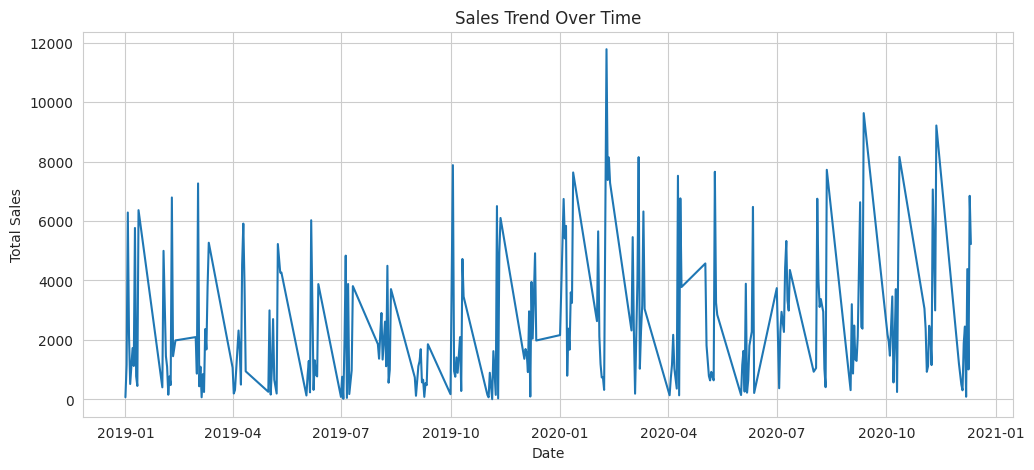

In [38]:
sales_trend = df.groupby(order_date_col)[sales_col].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=sales_trend, x=order_date_col, y=sales_col)
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


 Monthly sales trend

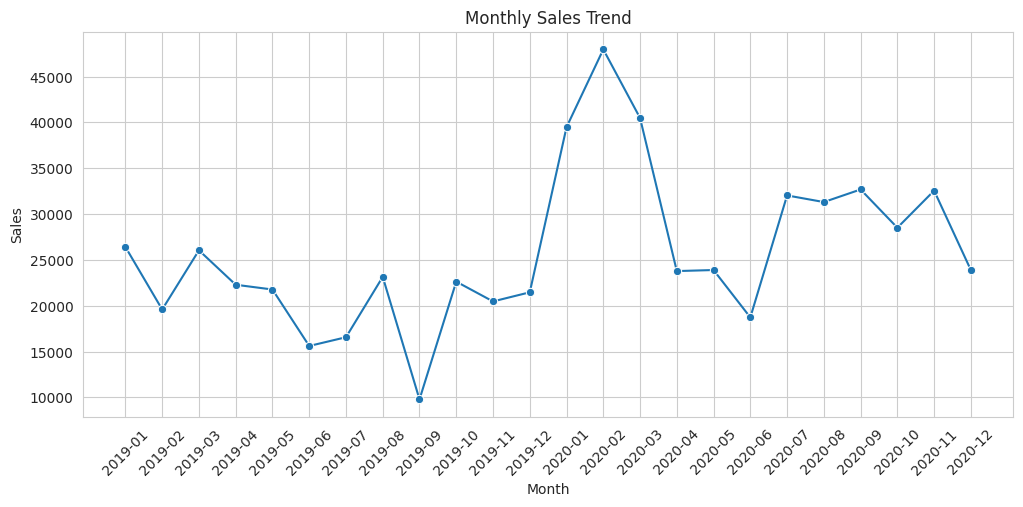

,month,sales
0,2019-01,26416.4810
1,2019-02,19598.7350
2,2019-03,26053.3750
3,2019-04,22296.3940
4,2019-05,21777.4588


In [39]:
df['month'] = df[order_date_col].dt.to_period('M').astype(str)
monthly_sales = df.groupby('month')[sales_col].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_sales, x='month', y=sales_col, marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()
monthly_sales.head()


Correlation heatmap

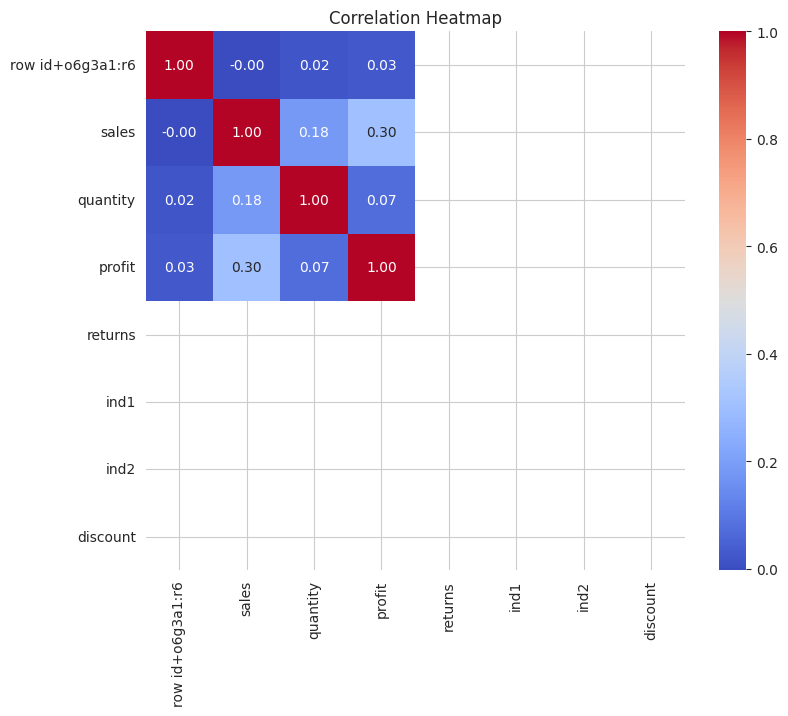

In [40]:
num_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(9,7))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()


Outlier detection and visualization

Select numeric columns

In [44]:
numeric_data = df[[sales_col, profit_col, discount_col, quantity_col]].copy()
z_scores = np.abs(zscore(numeric_data, nan_policy='omit'))
outlier_mask = (z_scores > 3).any(axis=1)
print("Outliers detected:", outlier_mask.sum(), "->", f"{100*outlier_mask.sum()/len(df):.2f}%")



Outliers detected: 81 -> 3.36%


Visualize outliers with a boxplot

,order date,sales,profit,discount,quantity
32,2019-11-01,54.9920,8.9362,0,14
93,2019-02-02,4749.9500,2799.9840,0,5
176,2019-01-03,4899.9300,2400.9657,0,7
189,2019-03-03,3930.0720,-786.0144,0,3
228,2019-10-03,4158.9120,363.9048,0,8
230,2019-10-03,3357.6000,377.7300,0,3
383,2019-08-04,1088.7920,-1850.9464,0,4
541,2019-05-05,1685.8800,320.3172,0,6
555,2019-07-05,3999.9500,1159.9855,0,5
733,2019-02-06,51.6480,18.7224,0,12


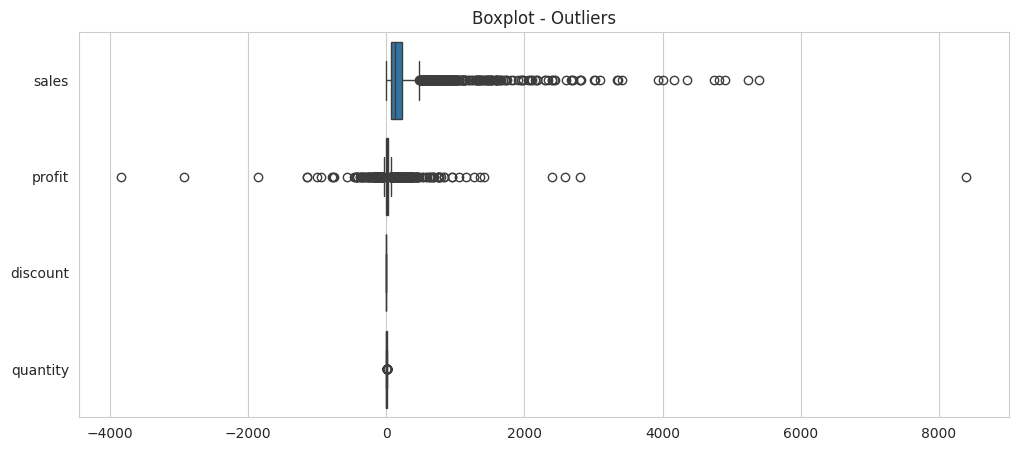

In [45]:
outliers_df = df[outlier_mask].copy()
display(outliers_df[[order_date_col, sales_col, profit_col, discount_col, quantity_col]].head(20))
plt.figure(figsize=(12,5))
sns.boxplot(data=numeric_data, orient='h')
plt.title("Boxplot - Outliers")
plt.show()

ARIMA forecasting



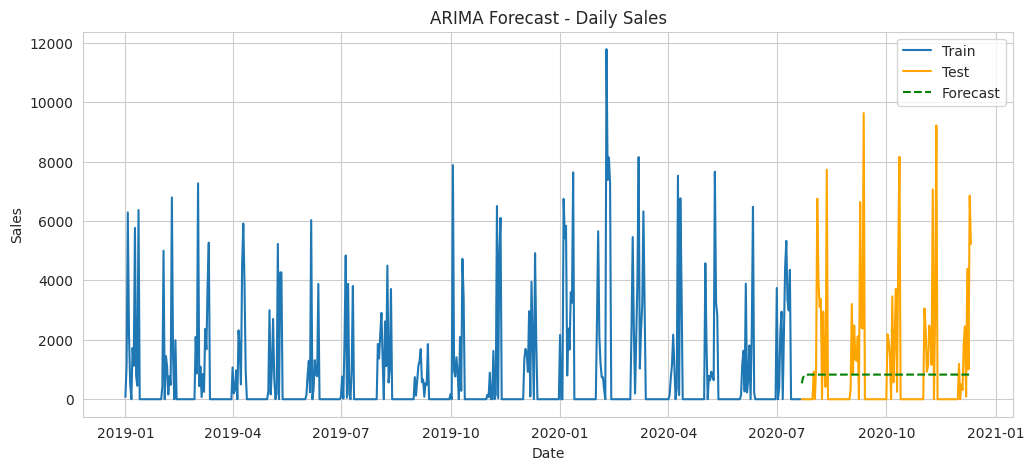

ARIMA RMSE: 2026.168


In [15]:
ts = df.groupby(order_date_col)[sales_col].sum().sort_index()
ts = ts.asfreq('D').fillna(0)
train_size = int(len(ts) * 0.8)
train_ts, test_ts = ts[:train_size], ts[train_size:]
model = ARIMA(train_ts, order=(1,1,1))
res = model.fit()
forecast = res.forecast(steps=len(test_ts))
plt.figure(figsize=(12,5))
plt.plot(train_ts.index, train_ts.values, label='Train')
plt.plot(test_ts.index, test_ts.values, label='Test', color='orange')
plt.plot(test_ts.index, forecast.values, label='Forecast', linestyle='--', color='green')
plt.legend()
plt.title("ARIMA Forecast - Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()
rmse = np.sqrt(mean_squared_error(test_ts.values, forecast.values))
print("ARIMA RMSE:", round(rmse,3))


Predictive Modeling (Classification)

Logistic Regression
Accuracy: 0.589
Recall: 0.986
Precision: 0.58
              precision    recall  f1-score   support

           0       0.80      0.07      0.14        54
           1       0.58      0.99      0.73        70

    accuracy                           0.59       124
   macro avg       0.69      0.53      0.43       124
weighted avg       0.68      0.59      0.47       124

Random Forest
Accuracy: 0.71
Recall: 0.814
Precision: 0.713
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        54
           1       0.71      0.81      0.76        70

    accuracy                           0.71       124
   macro avg       0.71      0.69      0.70       124
weighted avg       0.71      0.71      0.70       124



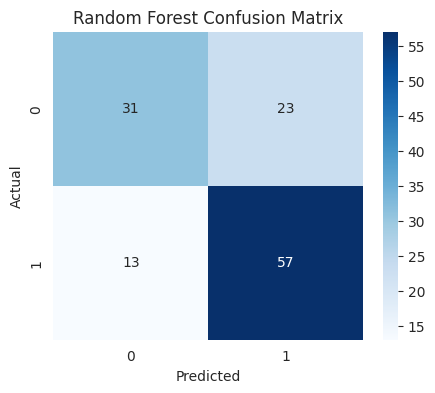

In [46]:
if customer_col is None or order_col is None:
    print("Skipping classification - missing customer or order id")
else:
    cust_orders = df.groupby(customer_col)[order_col].nunique().reset_index().rename(columns={order_col:'unique_orders'})
    cust_orders['repurchase'] = (cust_orders['unique_orders'] > 1).astype(int)
    cust_features = df.groupby(customer_col).agg({
        sales_col: 'mean',
        discount_col: 'mean',
        profit_col: 'mean',
        quantity_col: 'mean'
    }).reset_index().rename(columns={
        sales_col:'avg_sales', discount_col:'avg_discount', profit_col:'avg_profit', quantity_col:'avg_quantity'
    })
    data_cust = pd.merge(cust_orders[[customer_col,'repurchase']], cust_features, on=customer_col, how='left').dropna()
    X = data_cust[['avg_sales','avg_discount','avg_profit','avg_quantity']]
    y = data_cust['repurchase']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    lr = LogisticRegression()
    lr.fit(X_train_s, y_train)
    y_pred_lr = lr.predict(X_test_s)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    def print_eval(y_true, y_pred, name):
        print(name)
        print("Accuracy:", round(accuracy_score(y_true, y_pred),3))
        print("Recall:", round(recall_score(y_true, y_pred, zero_division=0),3))
        print("Precision:", round(precision_score(y_true, y_pred, zero_division=0),3))
        print(classification_report(y_true, y_pred, zero_division=0))

    print_eval(y_test, y_pred_lr, "Logistic Regression")
    print_eval(y_test, y_pred_rf, "Random Forest")
    
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
    plt.title("Random Forest Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
